# Read an SHP file and project it into discrete gridpoints

In this notebook we read an SHP file and we create a mesh grid of the same size and location as the SHP area. 

We first load useful libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


While we will have the SHP as a geopandas, we will be using its boundaries for plotting partial results

In [5]:
perimeter = gp.read_file('../../DATA/Fire_Perimeter.shp')
x_min, y_min, x_max, y_max = perimeter.total_bounds

The shapefile describes in this dataset the perimeter of the Paradise wildfire that occurred in California. 

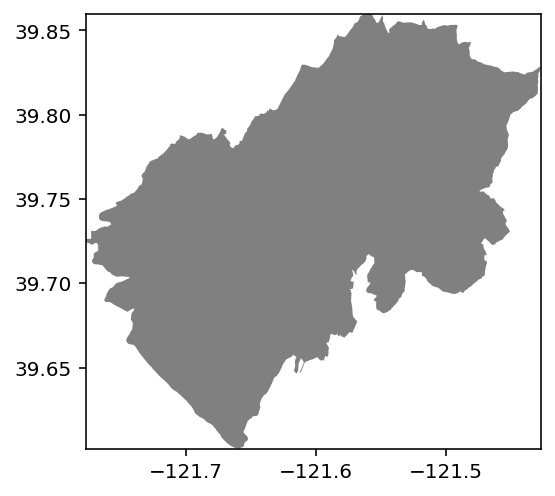

In [8]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
perimeter.plot(ax=ax, color='grey');

We now define a shapefile grid with the rectangles containing the original features, on which we will project the SHP features. 

In [9]:
n_cells=100
cell_size = (x_max-x_min)/n_cells
grid_cells = []

for x0 in np.arange(x_min, x_max+cell_size, cell_size ):
    for y0 in np.arange(y_min, y_max+cell_size, cell_size):
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )

The variable grid_cells is a collection of rectangular polygons. 

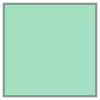

In [13]:
grid_cells[0]

We now convert this shapefile into geopandas

In [15]:
cell = gp.GeoDataFrame(grid_cells, columns=['geometry'])
cell

,geometry
0,"POLYGON ((-121.78113 39.60192, -121.78113 39.6..."
1,"POLYGON ((-121.78113 39.60543, -121.78113 39.6..."
2,"POLYGON ((-121.78113 39.60895, -121.78113 39.6..."
3,"POLYGON ((-121.78113 39.61246, -121.78113 39.6..."
4,"POLYGON ((-121.78113 39.61597, -121.78113 39.6..."
...,...
7645,"POLYGON ((-121.42649 39.84772, -121.42649 39.8..."
7646,"POLYGON ((-121.42649 39.85123, -121.42649 39.8..."
7647,"POLYGON ((-121.42649 39.85474, -121.42649 39.8..."
7648,"POLYGON ((-121.42649 39.85825, -121.42649 39.8..."


We calculate the position of each centroid of each rectangle of the grid. 

In [17]:
cell['centroids'] = cell['geometry'].centroid
cell

,geometry,centroids
0,"POLYGON ((-121.78113 39.60192, -121.78113 39.6...",POINT (-121.77938 39.60368)
1,"POLYGON ((-121.78113 39.60543, -121.78113 39.6...",POINT (-121.77938 39.60719)
2,"POLYGON ((-121.78113 39.60895, -121.78113 39.6...",POINT (-121.77938 39.61070)
3,"POLYGON ((-121.78113 39.61246, -121.78113 39.6...",POINT (-121.77938 39.61421)
4,"POLYGON ((-121.78113 39.61597, -121.78113 39.6...",POINT (-121.77938 39.61772)
...,...,...
7645,"POLYGON ((-121.42649 39.84772, -121.42649 39.8...",POINT (-121.42473 39.84947)
7646,"POLYGON ((-121.42649 39.85123, -121.42649 39.8...",POINT (-121.42473 39.85298)
7647,"POLYGON ((-121.42649 39.85474, -121.42649 39.8...",POINT (-121.42473 39.85649)
7648,"POLYGON ((-121.42649 39.85825, -121.42649 39.8...",POINT (-121.42473 39.86001)


The cells look like as follows 

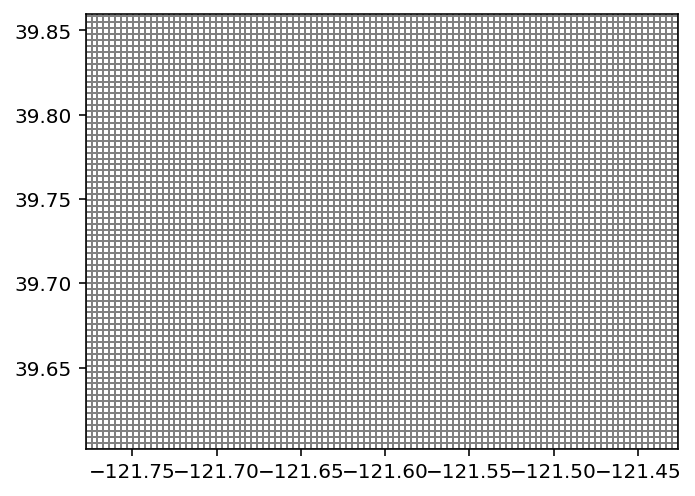

In [7]:
fig,ax = plt.subplots(1,1,dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
cell.plot(ax=ax, facecolor="none", edgecolor='grey');

The function sjoin( ) allows us to merge the cells dataframe and the perimeter dataframe

In [19]:
merged = gp.sjoin(perimeter, cell)
merged

,id,geometry,index_right,centroids
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",4418,POINT (-121.57572 39.84245)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",4193,POINT (-121.58626 39.84245)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",4343,POINT (-121.57923 39.84245)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",4493,POINT (-121.57221 39.84245)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",4568,POINT (-121.56870 39.84245)
...,...,...,...,...
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",1881,POINT (-121.69159 39.62475)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",2106,POINT (-121.68106 39.62475)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",2031,POINT (-121.68457 39.62475)
0,None,"POLYGON ((-121.77337 39.72297, -121.77418 39.7...",1956,POINT (-121.68808 39.62475)


We now assign a value to each of the cells based on aggregation 

In [9]:
merged['aggr']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'aggr'] = dissolve.aggr.values
cell

,geometry,centroids,aggr
0,"POLYGON ((-121.78113 39.60192, -121.78113 39.6...",POINT (-121.77938 39.60368),NaN
1,"POLYGON ((-121.78113 39.60543, -121.78113 39.6...",POINT (-121.77938 39.60719),NaN
2,"POLYGON ((-121.78113 39.60895, -121.78113 39.6...",POINT (-121.77938 39.61070),NaN
3,"POLYGON ((-121.78113 39.61246, -121.78113 39.6...",POINT (-121.77938 39.61421),NaN
4,"POLYGON ((-121.78113 39.61597, -121.78113 39.6...",POINT (-121.77938 39.61772),NaN
...,...,...,...
7645,"POLYGON ((-121.42649 39.84772, -121.42649 39.8...",POINT (-121.42473 39.84947),NaN
7646,"POLYGON ((-121.42649 39.85123, -121.42649 39.8...",POINT (-121.42473 39.85298),NaN
7647,"POLYGON ((-121.42649 39.85474, -121.42649 39.8...",POINT (-121.42473 39.85649),NaN
7648,"POLYGON ((-121.42649 39.85825, -121.42649 39.8...",POINT (-121.42473 39.86001),NaN


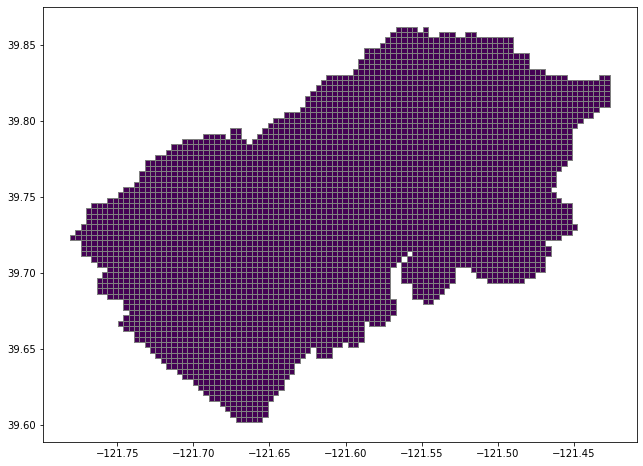

In [13]:
cell.plot(column='aggr', figsize=(12, 8), cmap='viridis', vmax=100, edgecolor="grey");